In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d quadeer15sh/amur-tiger-reidentification

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/amur-tiger-reidentification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 225M/227M [00:03<00:00, 79.8MB/s]
100% 227M/227M [00:03<00:00, 62.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/amur-tiger-reidentification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
train_dir = r'../content/Amur Tigers/train'
test_dir = r'../content/Amur Tigers/test'
train_csvpath = r'../content/Amur Tigers/reid_list_train.csv'
test_csvpath = r'../content/Amur Tigers/reid_list_test.csv'

In [6]:
df = pd.read_csv(train_csvpath)
df.head()

,250,003597.jpg
0,256,003523.jpg
1,171,003900.jpg
2,247,002636.jpg
3,238,002249.jpg
4,264,003370.jpg


In [7]:
# There unique ID's assigned to each tiger and multiple images are there in the dataset
# Renaming the columns name
df.columns=['labels', 'filepaths']
# adding the whole directory of the image in 'filepaths' column
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(train_dir,x))
df['labels']=df['labels'].apply(lambda x: str(x))
df.head()

,labels,filepaths
0,256,../content/Amur Tigers/train/003523.jpg
1,171,../content/Amur Tigers/train/003900.jpg
2,247,../content/Amur Tigers/train/002636.jpg
3,238,../content/Amur Tigers/train/002249.jpg
4,264,../content/Amur Tigers/train/003370.jpg


In [8]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=12, stratify=df['labels'])
# defining validation and test dataset
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=12, stratify=temp_df['labels'])

print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  1508   test_df length:  189   valid_df length:  189


In [9]:
# getting the no. of classes
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

The number of classes in the dataset is:  107


In [10]:
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

            CLASS               IMAGE COUNT 
              0                     10      
              1                      8      
             100                    17      
             106                    14      
             108                    11      
             109                     8      
             114                    11      
             115                     9      
             117                     9      
              12                     9      
             124                    10      
             126                    10      
             129                     8      
              13                    11      
             130                     9      
             132                     8      
             136                    30      
             139                     9      
             142                    10      
             145                    13      
             148                     8      
          

In [11]:
# classes with minimum and maximum no. of training images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images = ',max_value, '\n', min_class, ' has the least images = ', min_value)

153  has the most images =  78 
 1  has the least images =  8


In [12]:
# average height and width of the training images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height = ', ht//100, ' average width = ', wt//100, 'aspect ratio = ', ht/wt)

average height =  396  average width =  586 aspect ratio =  0.6749186444720836


## Balancing the Dataframe

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import shutil
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report


In [14]:
def balance(df, n, working_dir, img_size):
    def augment(df,n, working_dir, img_size):
        aug_dir=os.path.join(working_dir, 'aug')
        os.mkdir(aug_dir)
        for label in df['labels'].unique():
            dir_path=os.path.join(aug_dir,label)
            os.mkdir(dir_path)
        # create and store the augmented images
        total=0
        gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                      height_shift_range=.2, zoom_range=.2)
        groups=df.groupby('labels') # group by class
        for label in df['labels'].unique():  # for every class
            group=groups.get_group(label)  # a dataframe holding only rows with the specified label
            sample_count=len(group)   # determine how many samples there are in this class
            if sample_count< n: # if the class has less than target number of images
                aug_img_count=0
                delta=n - sample_count  # number of augmented images to create
                target_dir=os.path.join(aug_dir, label)  # define where to write the images
                msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
                print(msg, '\r', end='') # prints over on the same line
                aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                                class_mode=None, batch_size=1, shuffle=False,
                                                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                save_format='jpg')
                while aug_img_count<delta:
                    images=next(aug_gen)
                    aug_img_count += len(images)
                total +=aug_img_count
        print('Total Augmented images created= ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
        print('Length of augmented dataframe is now ', len(df))
        return df

    df=df.copy()
    print('Initial length of dataframe is ', len(df), '\n')
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if 'aug' in os.listdir(working_dir):
        print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images', flush=True)
        ans=input(' ')
        if ans == 'D' or ans == 'd':
            shutil.rmtree(aug_dir) # start with an clean empty directory
            return augment(df,n, working_dir, img_size)

        else:
            return df
    else:
        return augment(df,n, working_dir, img_size)

In [15]:
n=100 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(256,350) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  1508 

Found 78 validated image filenames.
Found 18 validated image filenames.
Found 17 validated image filenames.
Found 10 validated image filenames.
Found 10 validated image filenames.
Found 39 validated image filenames.
Found 38 validated image filenames.
Found 9 validated image filenames.
Found 8 validated image filenames.
Found 9 validated image filenames.
Found 77 validated image filenames.
Found 11 validated image filenames.
Found 15 validated image filenames.
Found 10 validated image filenames.
Found 13 validated image filenames.
Found 22 validated image filenames.
Found 13 validated image filenames.
Found 24 validated image filenames.
Found 17 validated image filenames.
Found 9 validated image filenames.
Found 10 validated image filenames.
Found 21 validated image filenames.
Found 33 validated image filenames.
Found 11 validated image filenames.
Found 9 validated image filenames.
Found 21 validated image filenames.
Found 26 validated image filen

In [16]:
batch_size = 30

trgen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 10700 validated image filenames belonging to 107 classes.
Found 189 validated image filenames belonging to 107 classes.


In [17]:
# for test dataset
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 189 validated image filenames belonging to 107 classes.


In [18]:
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

test batch size:  63   test steps:  3  number of classes :  107


## Visualizing the images

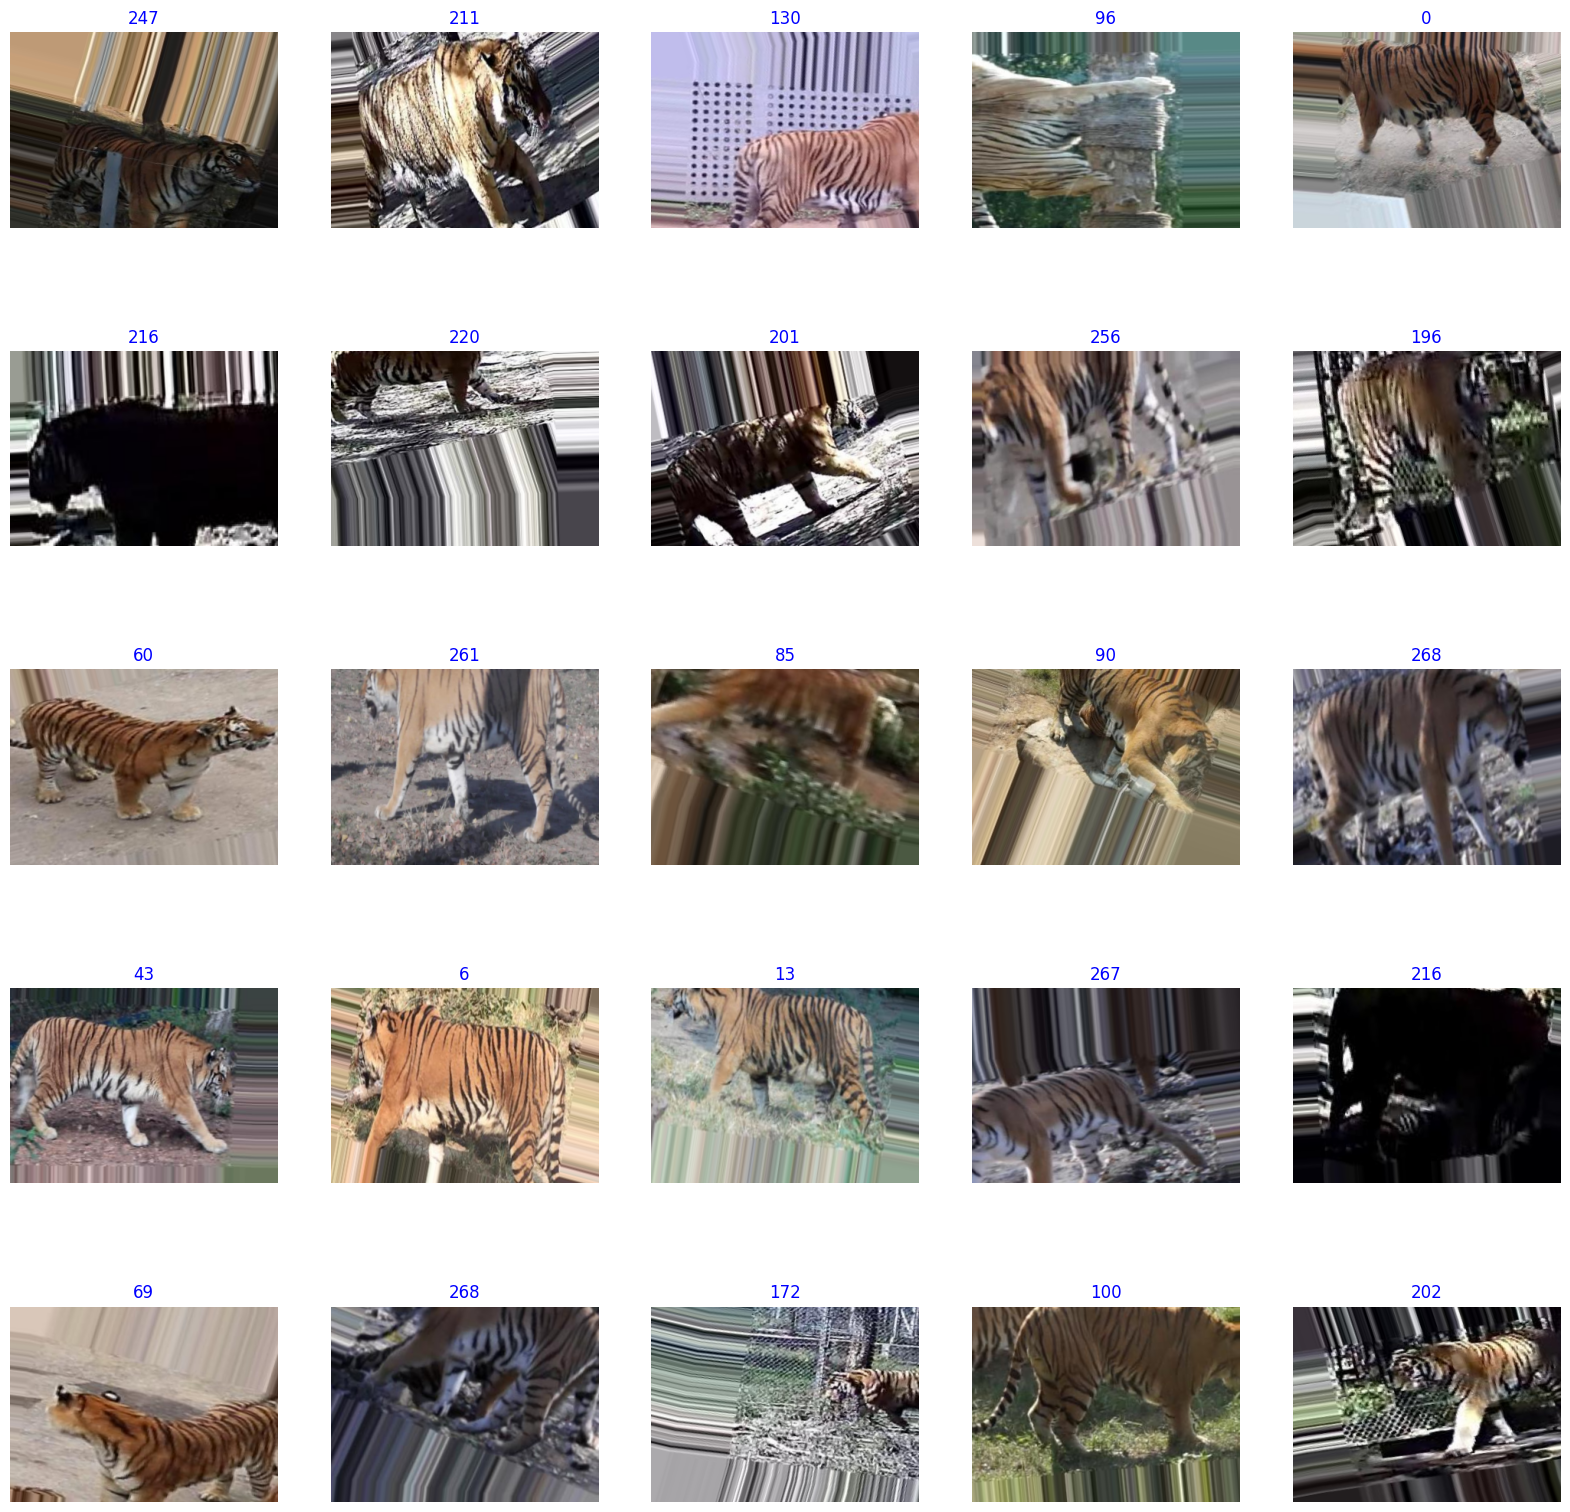

In [19]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [20]:
img_shape=(img_size[0], img_size[1], 3)

model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False,
                                             weights="imagenet",
                                             input_shape=img_shape,
                                             pooling='max')
base_model.trainable=True
# Exclude the last 3 layers of the model.
#conv = base_model.layers[-3].output


43941136/43941136 [==============================] - 0s 0us/step


In [21]:
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256 ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=0.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 350, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 350, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 350, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 350, 3)          0         ['normalization[0][0]']   

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(
    filepath='EfficientNetB3.hdf5',  # Save the best model with this file name
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    save_best_only=True,  # Save only the best model
    save_weights_only=True  # Save only the weights of the model
)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=40, min_delta=0.001)

In [24]:
epochs = 10
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=[checkpoint,Earlystop],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/10
357/357 [==============================] - 421s 1s/step - loss: 1.5426 - accuracy: 0.6490 - val_loss: 0.2744 - val_accuracy: 0.9101
Epoch 2/10
357/357 [==============================] - 356s 997ms/step - loss: 0.2173 - accuracy: 0.9450 - val_loss: 0.2450 - val_accuracy: 0.9471
Epoch 3/10
357/357 [==============================] - 361s 1s/step - loss: 0.1101 - accuracy: 0.9701 - val_loss: 0.1653 - val_accuracy: 0.9524
Epoch 4/10
357/357 [==============================] - 356s 995ms/step - loss: 0.0781 - accuracy: 0.9807 - val_loss: 0.1309 - val_accuracy: 0.9418
Epoch 5/10
357/357 [==============================] - 359s 1s/step - loss: 0.0641 - accuracy: 0.9825 - val_loss: 0.1199 - val_accuracy: 0.9630
Epoch 6/10
357/357 [==============================] - 357s 999ms/step - loss: 0.0490 - accuracy: 0.9884 - val_loss: 0.1236 - val_accuracy: 0.9735
Epoch 7/10
357/357 [==============================] - 358s 1s/step - loss: 0.0399 - accuracy: 0.9897 - val_loss: 0.1023 - val_accurac

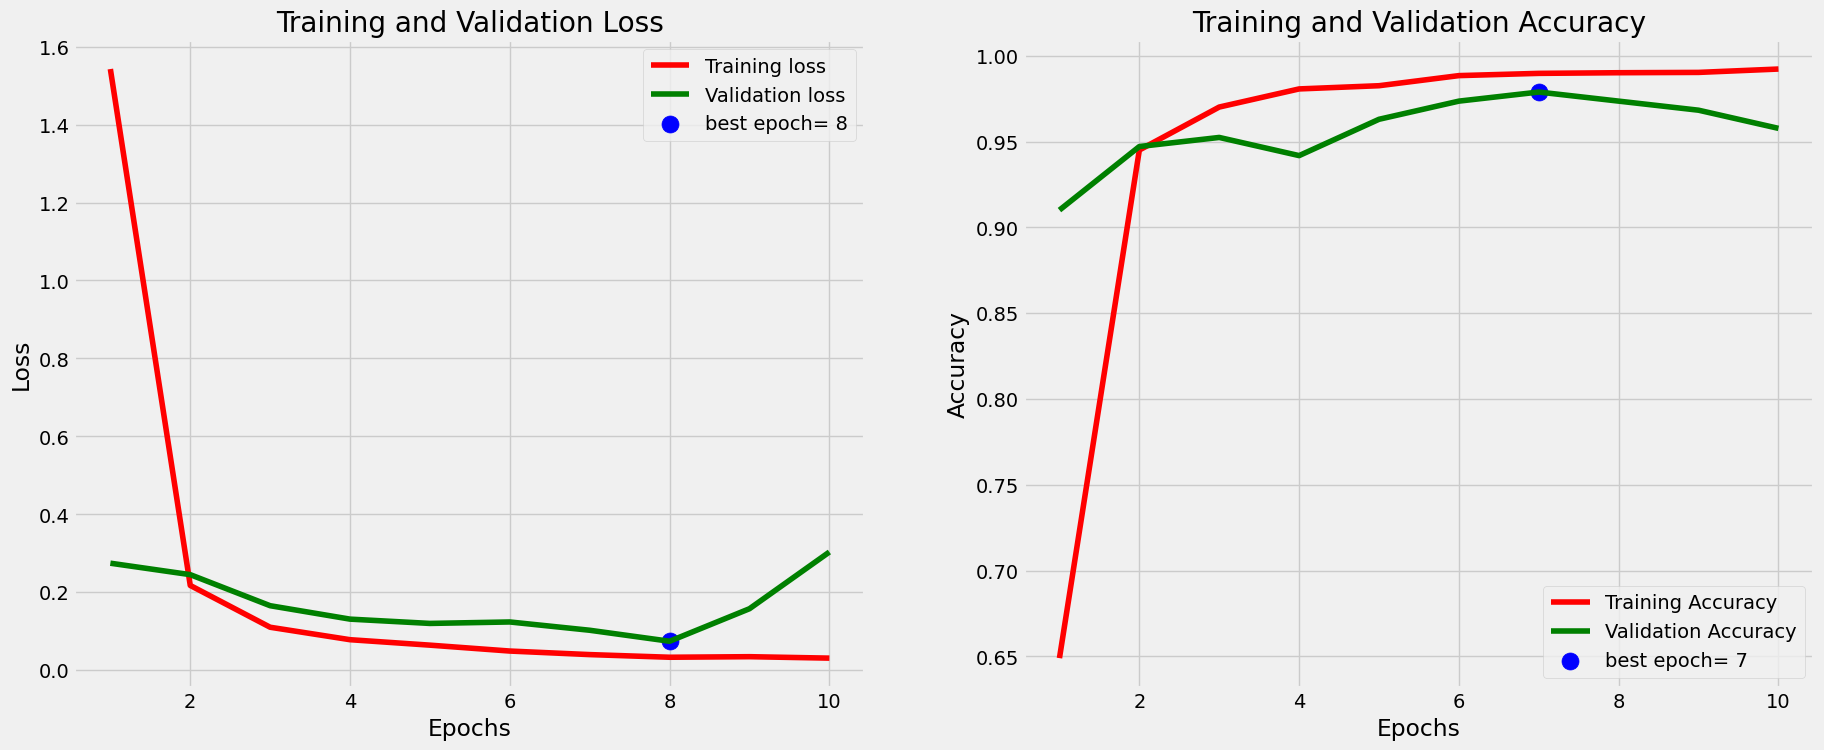

In [25]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

## Classification report on test data

In [26]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

3/3 [==============================] - 8s 206ms/step
there were 6 errors in 189 tests for an accuracy of  96.83
Classification Report:
----------------------
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     1.0000    1.0000    1.0000         1
         100     1.0000    1.0000    1.0000         2
         106     1.0000    1.0000    1.0000         1
         108     1.0000    1.0000    1.0000         1
         109     1.0000    1.0000    1.0000         1
         114     1.0000    1.0000    1.0000         2
         115     1.0000    1.0000    1.0000         1
         117     1.0000    1.0000    1.0000         1
          12     1.0000    1.0000    1.0000         1
         124     1.0000    1.0000    1.0000         1
         126     1.0000    1.0000    1.0000         1
         129     1.0000    1.0000    1.0000         1
          13     1.0000    1.0000    1.0000         2
         130     1.0000    1.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
